<a href="https://colab.research.google.com/github/Vedauvoo/TPQ-CPF/blob/main/Week07_Test_Project_KB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

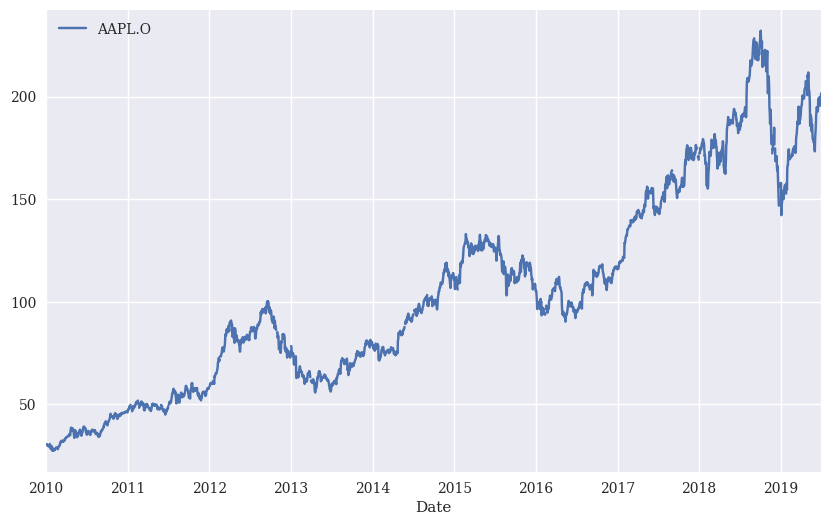

In [1]:
#Date: June 20, 2024
#Author: Kameron Behnam
#Email: k.behnam@yahoo.com
#TPQ Cohort:  May 2024
#Week 07 Test Project: Algorithmic Trading
#
#
#Import Libraries
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Read File Info From http://hilpisch.com/ref_eikon_eod_data.csv
url = 'http://hilpisch.com/ref_eikon_eod_data.csv'
symbol = 'AAPL.O'
raw = pd.read_csv(url,index_col=0,parse_dates=True)
data = pd.DataFrame(raw[symbol].loc[:])
data.columns = [symbol]
data.plot(figsize=(10, 6));

In [2]:
#Strategy Code
lags = 5
window = 20
def add_lags(data, symbol, lags, window):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    #Log Return
    df['r'] = np.log(df / df.shift(1))
    #Direction
    df['d'] = np.where(df['r'] > 0, 1, 0)
    #Get Std Dev of Log Return
    lr_sigma = df['r'].std()
    #Log Return as 5 Categories
    #Divide the Categories based on Standard Devation of "r"
    df['d_cat'] = np.digitize(df['r'], bins=[-2*lr_sigma, -1*lr_sigma, lr_sigma, 2*lr_sigma])
    #SMA1
    df['sma1'] = df[symbol].rolling(50).mean()
    #SMA2
    df['sma2'] = df[symbol].rolling(200).mean()
    #Difference in SMAs
    df['sma_diff'] = df['sma1'] - df['sma2']
    #EMA1
    df['EMA1'] = df[symbol].ewm(span=50, adjust=False).mean()
    #EMA2
    df['EMA2'] = df[symbol].ewm(span=200, adjust=False).mean()
    #Difference in EMAs
    df['ema_diff'] = df['EMA1'] - df['EMA2']
    #volatility 1
    df['vol1'] = df['r'].rolling(125).std()
    #volatility 2
    df['vol2'] = df['r'].rolling(150).std()
    df.dropna(inplace=True)
    #features = ['r', 'd', 'd_cat', 'sma1', 'sma2', 'sma_diff','EMA1', 'EMA2', 'ema_diff', 'vol1', 'vol2']
    features = ['r', 'd', 'd_cat','sma_diff','ema_diff','vol1','vol2']
    #The combo below had OOS performance > 3.0 when vol2's window set to 150
    #features = ['r','d','vol2']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

data, cols = add_lags(data, symbol, lags, window)
c = data['d'].value_counts()

In [ ]:
####################################Start of DecisionTreeClassifier (DTC) Model######################################################

In [3]:
#DTC Model Defintion, Fit, & Prediction on 100% IN SAMPLE Data
model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=5)
model.fit(data[cols], data['d'])
data['p'] = model.predict(data[cols])
data['p'].value_counts()

p
1    2185
Name: count, dtype: int64

In [4]:
#Accuracy of DTC Model IN SAMPLE Data
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(data['d'], data['p'])

0.5208237986270023

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(data[cols])

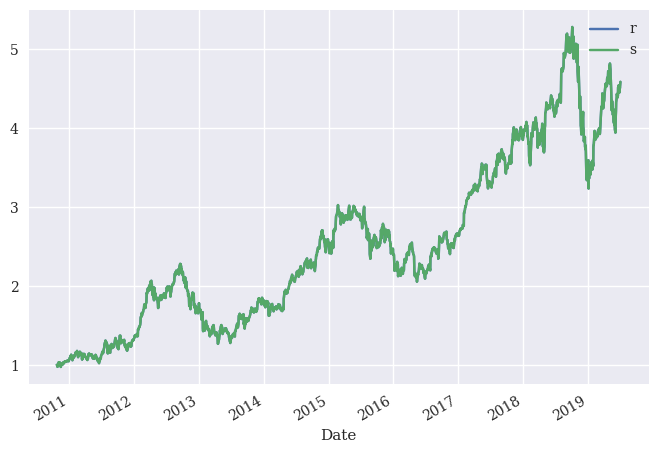

In [6]:
#Backtesting Code with ALL DATA IN-SAMPLE; NOT Normalized; NO STOP LOSS
data['pred'] = np.where(data['p']>0,1,-1)
data['s'] = data['pred'] * data['r']
data[['r', 's']].sum().apply(np.exp)  # gross returns
data[['r', 's']].cumsum().apply(np.exp).plot();  # gross returns over time

In [7]:
#Train-Test Split with 70% IN SAMPLE and 30% OUT OF SAMPLE, Non-Normalized
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [8]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Non-Normalized
model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=5)
model.fit(train[cols], train['d'])
test['p'] = model.predict(test[cols])
test['p'].value_counts()

p
1    379
0    277
Name: count, dtype: int64

In [9]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Non-Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.4969512195121951

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

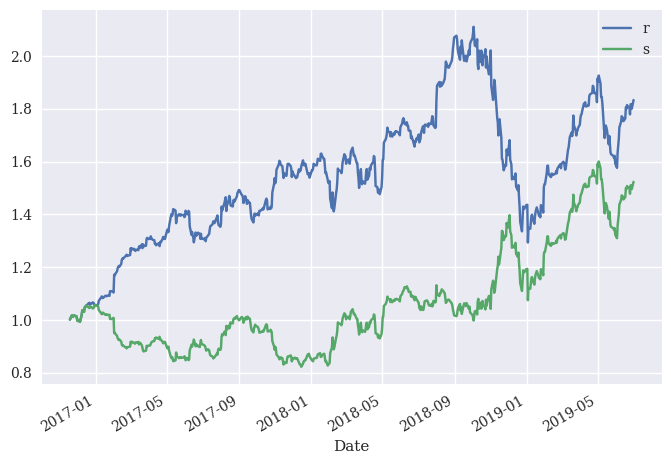

In [10]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [11]:
#Normalize the In-Sample Training & Out of Sample Test Data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

In [12]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Normalized
model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=5)
model.fit(train_[cols], train['d'])
test['p'] = model.predict(test_[cols])
test['p'].value_counts()

p
1    379
0    277
Name: count, dtype: int64

In [13]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.4969512195121951

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

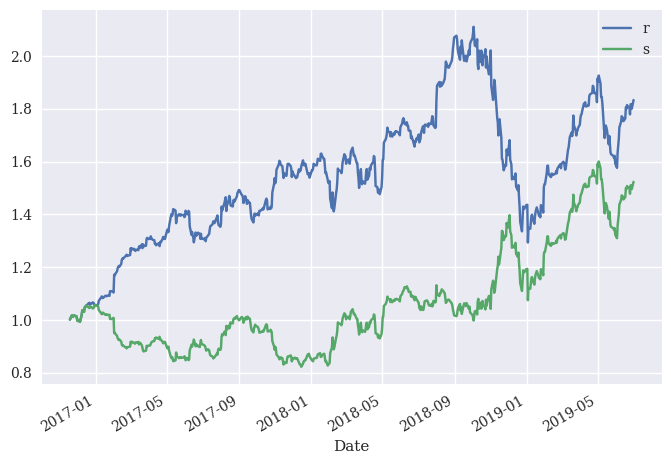

In [15]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [16]:
#Final Cumulative Performance of DTC Strategy
#30% Out of Sample; Normalized
test[['r','s']].cumsum().apply(np.exp)[-1:]

,r,s
Date,,
2019-07-01,1.833106,1.523158


In [ ]:
####################################Start of GaussianNB Model######################################################

In [17]:
#GaussianNB Model Defintion, Fit, & Prediction on 100% IN SAMPLE Data
model = GaussianNB()
model.fit(data[cols], data['d'])
data['p'] = model.predict(data[cols])
data['p'].value_counts()

p
0    1301
1     884
Name: count, dtype: int64

In [18]:
#Accuracy of GaussianNB Model IN SAMPLE Data
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(data['d'], data['p'])

0.5112128146453089

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(data[cols])

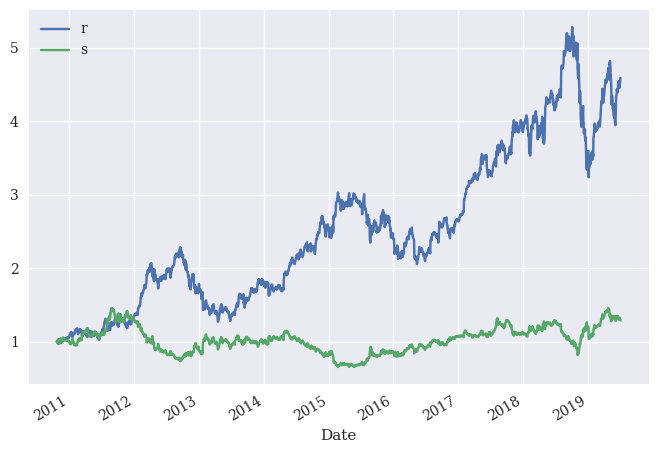

In [19]:
#Backtesting Code with ALL DATA IN-SAMPLE; NOT Normalized; NO STOP LOSS
data['pred'] = np.where(data['p']>0,1,-1)
data['s'] = data['pred'] * data['r']
data[['r', 's']].sum().apply(np.exp)  # gross returns
data[['r', 's']].cumsum().apply(np.exp).plot();  # gross returns over time

In [20]:
#Train-Test Split with 70% IN SAMPLE and 30% OUT OF SAMPLE, Non-Normalized
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [21]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; NON-Normalized
model = GaussianNB()
model.fit(train[cols], train['d'])
test['p'] = model.predict(test[cols])
test['p'].value_counts()

p
0    501
1    155
Name: count, dtype: int64

In [22]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Non-Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.49085365853658536

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

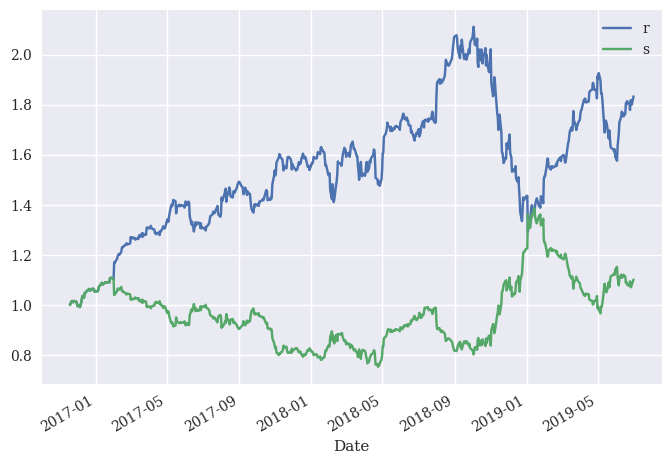

In [23]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [24]:
#Normalize the In-Sample Training & Out of Sample Test Data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

In [25]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Normalized
model = GaussianNB()
model.fit(train_[cols], train['d'])
test['p'] = model.predict(test_[cols])
test['p'].value_counts()

p
0    503
1    153
Name: count, dtype: int64

In [26]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.49085365853658536

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

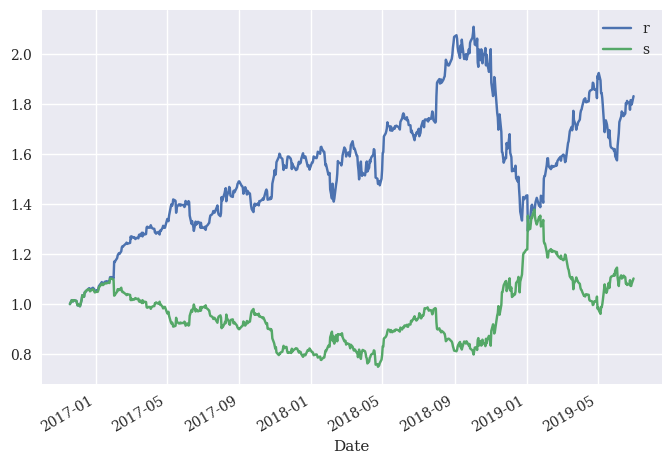

In [27]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [28]:
#Final Cumulative Performance of GaussianNB Strategy
#30% Out of Sample; Normalized
test[['r','s']].cumsum().apply(np.exp)[-1:]

,r,s
Date,,
2019-07-01,1.833106,1.103508


In [ ]:
####################################Start of SVC Regression Model######################################################

In [29]:
#SVC Model Defintion, Fit, & Prediction on 100% IN SAMPLE Data
model = SVC(C=1.0, kernel='poly', probability=True)
model.fit(data[cols], data['d'])
data['p'] = model.predict(data[cols])
data['p'].value_counts()

p
1    2143
0      42
Name: count, dtype: int64

In [30]:
#Accuracy of SVC Regression Model IN SAMPLE Data
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(data['d'], data['p'])

0.5217391304347826

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(data[cols])

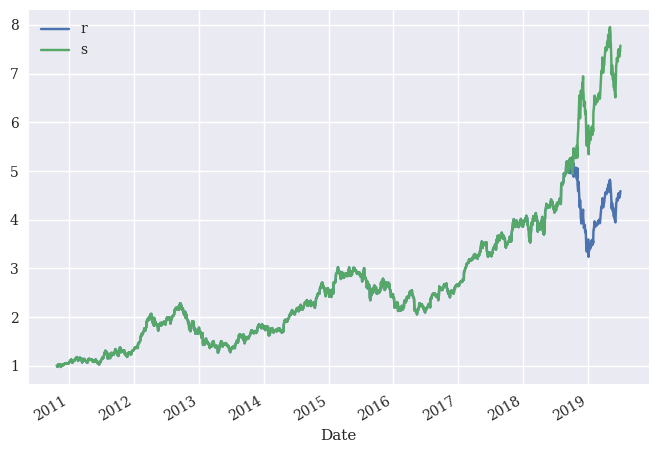

In [31]:
#Backtesting Code with ALL DATA IN-SAMPLE; NOT Normalized; NO STOP LOSS
data['pred'] = np.where(data['p']>0,1,-1)
data['s'] = data['pred'] * data['r']
data[['r', 's']].sum().apply(np.exp)  # gross returns
data[['r', 's']].cumsum().apply(np.exp).plot();  # gross returns over time

In [32]:
#Train-Test Split with 70% IN SAMPLE and 30% OUT OF SAMPLE, Non-Normalized
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [33]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; NON-Normalized
model = SVC(C=1.0, kernel='poly', probability=True)
model.fit(train[cols], train['d'])
test['p'] = model.predict(test[cols])
test['p'].value_counts()

p
0    349
1    307
Name: count, dtype: int64

In [34]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Non-Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.4969512195121951

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

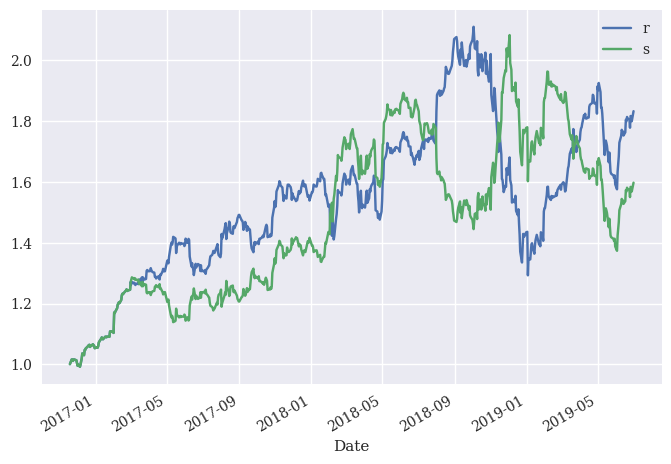

In [35]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [36]:
#Normalize the In-Sample Training & Out of Sample Test Data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

In [37]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Normalized
model = SVC(C=1.0, kernel='poly', probability=True)
model.fit(train_[cols], train['d'])
test['p'] = model.predict(test_[cols])
test['p'].value_counts()

p
0    343
1    313
Name: count, dtype: int64

In [38]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.5335365853658537

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

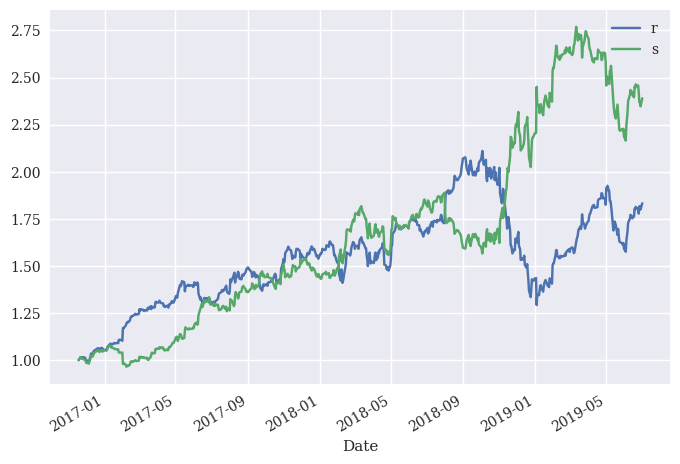

In [39]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [40]:
#Final Cumulative Performance of Logistic Regression Strategy
#30% Out of Sample; Normalized
test[['r','s']].cumsum().apply(np.exp)[-1:]

,r,s
Date,,
2019-07-01,1.833106,2.390169


In [ ]:
####################################Start of Logistic Regression Model####################################################

In [41]:
#Logistic Regression Model Defintion, Fit, & Prediction on 100% IN SAMPLE Data
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)
model.fit(data[cols], data['d'])
data['p'] = model.predict(data[cols])
data['p'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


p
1    1551
0     634
Name: count, dtype: int64

In [42]:
#Accuracy of Logistic Regression Model IN SAMPLE Data
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(data['d'], data['p'])

0.5391304347826087

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(data[cols])

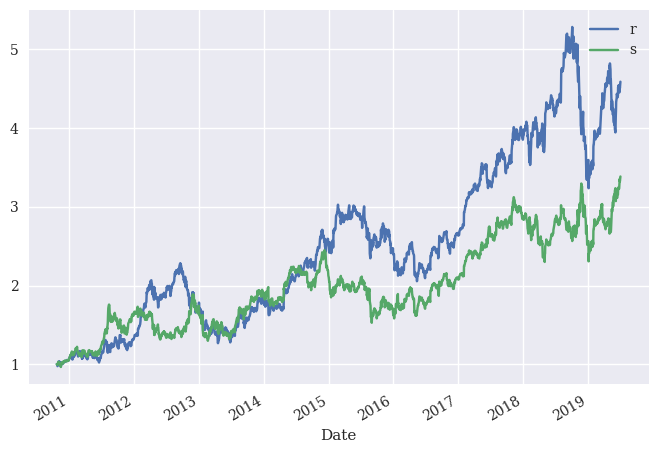

In [43]:
#Backtesting Code with ALL DATA IN-SAMPLE; NOT Normalized; NO STOP LOSS
data['pred'] = np.where(data['p']>0,1,-1)
data['s'] = data['pred'] * data['r']
data[['r', 's']].sum().apply(np.exp)  # gross returns
data[['r', 's']].cumsum().apply(np.exp).plot();  # gross returns over time

In [44]:
#Train-Test Split with 70% IN SAMPLE and 30% OUT OF SAMPLE, Non-Normalized
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [45]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; NON-Normalized
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)
model.fit(train[cols], train['d'])
test['p'] = model.predict(test[cols])
test['p'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


p
0    372
1    284
Name: count, dtype: int64

In [46]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Non-Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.5137195121951219

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

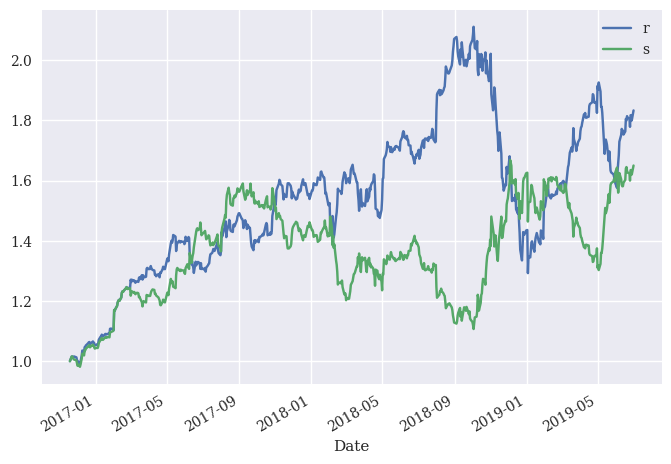

In [47]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [48]:
#Normalize the In-Sample Training & Out of Sample Test Data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

In [49]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Normalized
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)
model.fit(train_[cols], train['d'])
test['p'] = model.predict(test_[cols])
test['p'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


p
0    381
1    275
Name: count, dtype: int64

In [50]:
#Accuracy of Logistic Regression Model 70% IN SAMPLE & 30% OUT OF SAMPLE Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.5091463414634146

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

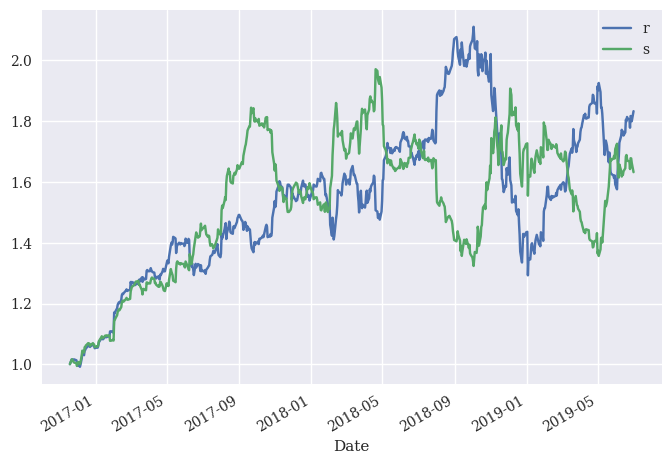

In [51]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [52]:
#Final Cumulative Performance of Logistic Regression Strategy
#30% Out of Sample; Normalized
test[['r','s']].cumsum().apply(np.exp)[-1:]

,r,s
Date,,
2019-07-01,1.833106,1.632557


In [ ]:
####################################Start of MLPClassifier Model##########################################################

In [53]:
#MLPClassifier Model Defintion, Fit, & Prediction on 100% IN SAMPLE Data
model = MLPClassifier(hidden_layer_sizes=[24, 24], max_iter=1000, random_state=100,shuffle=False)
model.fit(data[cols], data['d'])
data['p'] = model.predict(data[cols])
data['p'].value_counts()

p
1    1346
0     839
Name: count, dtype: int64

In [54]:
#Accuracy of MLPC Classifier Model IN SAMPLE Data
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(data['d'], data['p'])

0.6576659038901602

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(data[cols])

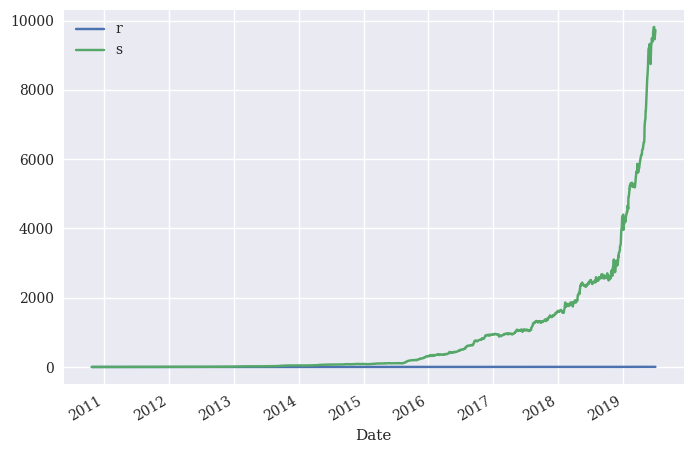

In [55]:
#Backtesting Code with ALL DATA IN-SAMPLE; NOT Normalized; NO STOP LOSS
data['pred'] = np.where(data['p']>0,1,-1)
data['s'] = data['pred'] * data['r']
data[['r', 's']].sum().apply(np.exp)  # gross returns
data[['r', 's']].cumsum().apply(np.exp).plot();  # gross returns over time

In [56]:
#Train-Test Split with 70% IN SAMPLE and 30% OUT OF SAMPLE, Non-Normalized
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [57]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; NON-Normalized
model = MLPClassifier(hidden_layer_sizes=[24, 24], max_iter=1000, random_state=100, shuffle=False)
model.fit(train[cols], train['d'])
test['p'] = model.predict(test[cols])
test['p'].value_counts()

p
0    442
1    214
Name: count, dtype: int64

In [58]:
#Accuracy of MLPC Classifier Model 70% IN SAMPLE & 30% OUT OF SAMPLE Non-Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.48323170731707316

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

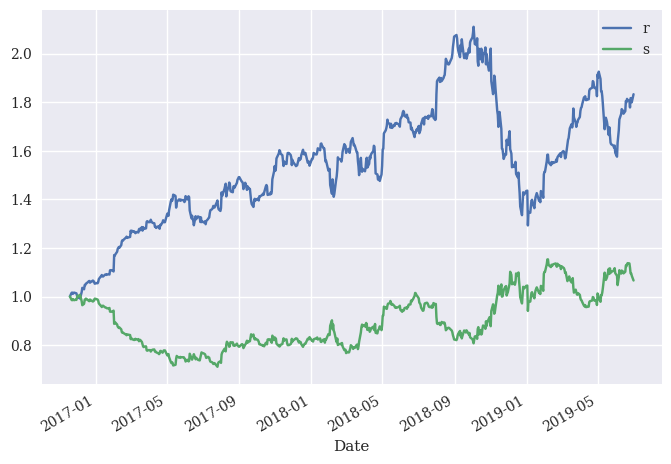

In [59]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [ ]:
test['s'][:50]

In [60]:
#Normalize the In-Sample Training & Out of Sample Test Data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

In [61]:
#Train model with 70% IN SAMPLE Data & make predictions based on 30% OUT OF SAMPLE Data; Normalized
model = MLPClassifier(hidden_layer_sizes=[24, 24], max_iter=1000, random_state=100, shuffle=False)
model.fit(train_[cols], train['d'])
test['p'] = model.predict(test_[cols])
test['p'].value_counts()

p
1    334
0    322
Name: count, dtype: int64

In [62]:
#Accuracy of MLPC Classifier Model 70% IN SAMPLE & 30% OUT OF SAMPLE Normalized
#Compare the prediction 'p' to the direction 'd' to get level of accuracy
accuracy_score(test['d'], test['p'])

0.5015243902439024

In [ ]:
#Show the probabilities behind the predictions
model.predict_proba(test[cols])

<Axes: xlabel='Date'>

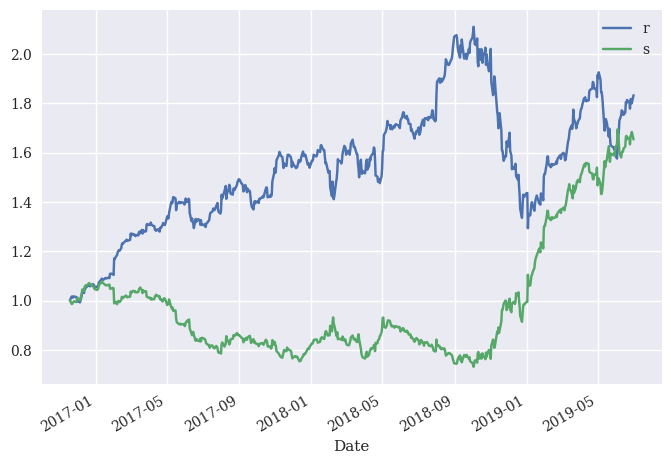

In [63]:
#Format Predictions to be either +1 for Long or -1 for Short
#Calculate the cumlative return of the Strategy, "s" vs the return of the asset "r"
#Plot performance of "s" vs "r" over the 30% OUT OF SAMPLE timeframe.
test['pred'] = np.where(test['p']>0,1,-1)
test['s'] = test['pred']*test['r']
test[['r','s']].sum().apply(np.exp)
test[['r','s']].cumsum().apply(np.exp).plot()

In [64]:
#Final Cumulative Performance of MLPClassifier Strategy
#30% Out of Sample; Normalized
test[['r','s']].cumsum().apply(np.exp)[-1:]

,r,s
Date,,
2019-07-01,1.833106,1.653679
